Name: Minh Phan

Library: Selenium 

URL: [https://www.selenium.dev/](https://www.selenium.dev/)

Description: 
This library is an open-source automation framework that provides a programming interface for controlling web browsers. Originally developed in 2004 by Jason Huggins at ThoughtWorks for automated testing, Selenium has evolved into the industry standard for browser automation and has become an indispensable tool for data scientists, QA engineers, and automation specialists worldwide.

In [29]:
# Import required libraries
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from selenium.common.exceptions import TimeoutException, NoSuchElementException
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import time
import random
from datetime import datetime


In [30]:
# CELL 2: Initialize Chrome WebDriver with Configuration
# ============================================================================
"""
Set up Chrome WebDriver with anti-detection features and optimal settings
"""
def initialize_driver(headless=False, wait_time=15):
    """Initialize Chrome WebDriver with custom options"""
    
    # Configure Chrome options
    chrome_options = webdriver.ChromeOptions()
    
    if headless:
        chrome_options.add_argument('--headless=new')
    
    # Anti-detection and performance settings
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument('--disable-blink-features=AutomationControlled')
    chrome_options.add_argument('--window-size=1920,1080')
    chrome_options.add_argument(
        'user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
        'AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'
    )
    
    # Initialize driver with automatic driver management
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=chrome_options)
    wait = WebDriverWait(driver, wait_time)
    
    print(f"✓ Chrome WebDriver initialized")
    print(f"✓ Browser version: {driver.capabilities['browserVersion']}")
    
    return driver, wait

# Initialize the driver (set headless=True to run without GUI)
driver, wait = initialize_driver(headless=False, wait_time=15)

✓ Chrome WebDriver initialized
✓ Browser version: 141.0.7390.108


In [33]:
# CELL 3: Helper Functions - Random Delays and Scrolling
# ============================================================================
"""
Utility functions to mimic human behavior and handle dynamic content
"""
def random_delay(min_seconds=2, max_seconds=4):
    """Add random delay to avoid detection"""
    delay = random.uniform(min_seconds, max_seconds)
    time.sleep(delay)
    print(f"Waited {delay:.2f} seconds")

def scroll_page(driver):
    """Scroll page to trigger lazy-loaded content"""
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(1)
    driver.execute_script("window.scrollTo(0, 0);")
    time.sleep(0.5)
    print("  ↕ Page scrolled")

# Test the functions
print("Testing helper functions:")
random_delay(1, 2)
print("Helper functions ready")


Testing helper functions:
Waited 1.94 seconds
Helper functions ready


In [34]:
# CELL 4: Safe Element Finding Function
# ============================================================================
"""
Robust element finding with error handling and custom timeouts
"""
def safe_find_element(driver, by, value, timeout=None, scroll=False):
    """
    Safely find an element with proper error handling
    
    Args:
        driver: Selenium WebDriver instance
        by: Selenium By locator strategy (e.g., By.CSS_SELECTOR)
        value: Locator value
        timeout: Optional custom timeout
        scroll: Whether to scroll before finding element
        
    Returns:
        WebElement or None if not found
    """
    try:
        if scroll:
            scroll_page(driver)
        
        if timeout:
            element = WebDriverWait(driver, timeout).until(
                EC.presence_of_element_located((by, value))
            )
        else:
            element = driver.find_element(by, value)
        
        print(f"Found element: {value}")
        return element
    
    except (TimeoutException, NoSuchElementException) as e:
        print(f"  Element not found: {value}")
        return None

print("Safe element finder ready")

Safe element finder ready


In [36]:
# CELL 5: Wait for Table Loading Function
# ============================================================================
"""
Wait for dynamic tables to fully load before scraping
"""
def wait_for_table_load(driver, timeout=20):
    """
    Wait for table to fully load on F1 website
    
    Args:
        driver: Selenium WebDriver instance
        timeout: Maximum wait time in seconds
        
    Returns:
        bool: True if table loaded successfully
    """
    try:
        # Wait for table body to be present and populated
        WebDriverWait(driver, timeout).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, "table tbody tr"))
        )
        time.sleep(2)  # Additional wait for JavaScript rendering
        print(" Table loaded successfully")
        return True
    
    except TimeoutException:
        print(" Timeout waiting for table to load")
        return False

print(" Table loading function ready")

 Table loading function ready


## Now we done with setting up all the functions to help us grab the data, let't bring them into actions using F1 season 2024 data from its offiical webiste

In [ ]:
 #CELL 6: Scrape Race Results Function
# ============================================================================
"""
Main function to scrape race results from F1 website
"""
def scrape_race_results(driver, year=2024):
    """
    Scrape race results for a specific F1 season
    
    Args:
        driver: Selenium WebDriver instance
        year: F1 season year
        
    Returns:
        pd.DataFrame: Race results data
    """
    print(f"\n{'='*60}")
    print(f"Scraping race results for {year} season...")
    print(f"{'='*60}")
    
    base_url = "https://www.formula1.com"
    race_results = []
    
    try:
        # Navigate to results page
        url = f"{base_url}/en/results/{year}/races"
        print(f"   Navigating to: {url}")
        driver.get(url)
        random_delay(3, 5)
        
        # Scroll to load content
        scroll_page(driver)
        
        # Wait for table to load
        if not wait_for_table_load(driver):
            print("   Could not load race results table")
            return pd.DataFrame()
        
        # Find table using multiple selectors
        table = None
        selectors = [
            "table",
            "table.f1-table",
            "div.resultsarchive-table table",
            ".race-result-table"
        ]
        
        for selector in selectors:
            try:
                table = driver.find_element(By.CSS_SELECTOR, selector)
                if table:
                    print(f"   Found table using selector: {selector}")
                    break
            except NoSuchElementException:
                continue
        
        if not table:
            print("   Could not find results table")
            return pd.DataFrame()
        
        # Extract table rows
        rows = table.find_elements(By.TAG_NAME, "tr")
        print(f"  → Found {len(rows)} rows in table")
        
        # Extract headers
        header_cells = rows[0].find_elements(By.TAG_NAME, "th")
        if not header_cells:
            header_cells = rows[0].find_elements(By.TAG_NAME, "td")
        
        headers = [cell.text.strip() for cell in header_cells]
        print(f"  Headers: {headers}")
        
        # Extract data rows
        for idx, row in enumerate(rows[1:], 1):
            try:
                cells = row.find_elements(By.TAG_NAME, "td")
                if len(cells) >= 4:
                    cell_data = [cell.text.strip() for cell in cells]
                    
                    race_data = {
                        'year': year,
                        'grand_prix': cell_data[0] if len(cell_data) > 0 else None,
                        'date': cell_data[1] if len(cell_data) > 1 else None,
                        'winner': cell_data[2] if len(cell_data) > 2 else None,
                        'car': cell_data[3] if len(cell_data) > 3 else None,
                        'laps': cell_data[4] if len(cell_data) > 4 else None,
                        'time': cell_data[5] if len(cell_data) > 5 else None,
                        'scraped_at': datetime.now().isoformat()
                    }
                    
                    if race_data['winner'] and race_data['winner'] != '':
                        race_results.append(race_data)
                        print(f"  {idx}. {race_data['grand_prix']} - {race_data['winner']}")
                        
            except Exception as e:
                print(f"  ⚠ Error parsing row {idx}: {e}")
                continue

        print(f"  Successfully scraped {len(race_results)} race results")
        return pd.DataFrame(race_results)
        
    except Exception as e:
        print(f"   Error scraping race results: {e}")
        import traceback
        traceback.print_exc()
        return pd.DataFrame()

print("Race results scraper ready")



Race results scraper ready


In [40]:
race_results

,year,grand_prix,date,winner,car,laps,time,scraped_at
0,2024,Bahrain,02 Mar,Max Verstappen,Red Bull Racing Honda RBPT,57,1:31:44.742,2025-10-26T16:35:10.346647
1,2024,Saudi Arabia,09 Mar,Max Verstappen,Red Bull Racing Honda RBPT,50,1:20:43.273,2025-10-26T16:35:10.417255
2,2024,Australia,24 Mar,Carlos Sainz,Ferrari,58,1:20:26.843,2025-10-26T16:35:10.486884
3,2024,Japan,07 Apr,Max Verstappen,Red Bull Racing Honda RBPT,53,1:54:23.566,2025-10-26T16:35:10.551752
4,2024,China,21 Apr,Max Verstappen,Red Bull Racing Honda RBPT,56,1:40:52.554,2025-10-26T16:35:10.647039
5,2024,Miami,05 May,Lando Norris,McLaren Mercedes,57,1:30:49.876,2025-10-26T16:35:10.754867
6,2024,Emilia-Romagna,19 May,Max Verstappen,Red Bull Racing Honda RBPT,63,1:25:25.252,2025-10-26T16:35:10.828600
7,2024,Monaco,26 May,Charles Leclerc,Ferrari,78,2:23:15.554,2025-10-26T16:35:10.907122
8,2024,Canada,09 Jun,Max Verstappen,Red Bull Racing Honda RBPT,70,1:45:47.927,2025-10-26T16:35:10.995777
9,2024,Spain,23 Jun,Max Verstappen,Red Bull Racing Honda RBPT,66,1:28:20.227,2025-10-26T16:35:11.089960


In [41]:
# CELL 7: Scrape Driver Standings Function
# ============================================================================
"""
Function to scrape driver championship standings
"""
def scrape_driver_standings(driver, year=2024):
    """
    Scrape driver championship standings for a specific season
    
    Args:
        driver: Selenium WebDriver instance
        year: F1 season year
        
    Returns:
        pd.DataFrame: Driver standings data
    """
    print(f"\n{'='*60}")
    print(f"Scraping driver standings for {year}...")
    print(f"{'='*60}")
    
    base_url = "https://www.formula1.com"
    driver_standings = []
    
    try:
        url = f"{base_url}/en/results/{year}/drivers"
        print(f"  → Navigating to: {url}")
        driver.get(url)
        random_delay(3, 5)
        
        scroll_page(driver)
        if not wait_for_table_load(driver):
            return pd.DataFrame()
        
        table = driver.find_element(By.CSS_SELECTOR, "table")
        rows = table.find_elements(By.TAG_NAME, "tr")
        print(f"  → Found {len(rows)} rows")
        
        for idx, row in enumerate(rows[1:], 1):
            try:
                cells = row.find_elements(By.TAG_NAME, "td")
                if len(cells) >= 4:
                    cell_data = [cell.text.strip() for cell in cells]
                    
                    driver_data = {
                        'year': year,
                        'position': cell_data[0] if len(cell_data) > 0 else None,
                        'driver': cell_data[1] if len(cell_data) > 1 else None,
                        'nationality': cell_data[2] if len(cell_data) > 2 else None,
                        'car': cell_data[3] if len(cell_data) > 3 else None,
                        'points': cell_data[4] if len(cell_data) > 4 else '0',
                        'scraped_at': datetime.now().isoformat()
                    }
                    
                    try:
                        driver_data['points'] = float(driver_data['points'])
                    except:
                        driver_data['points'] = 0.0
                    
                    if driver_data['driver'] and driver_data['driver'] != '':
                        driver_standings.append(driver_data)
                        print(f"  {driver_data['position']}. {driver_data['driver']} - {driver_data['points']} pts")
                        
            except Exception as e:
                print(f"  ⚠ Error parsing row {idx}: {e}")
                continue
        
        print(f"\n  ✓ Successfully scraped {len(driver_standings)} driver standings")
        return pd.DataFrame(driver_standings)
        
    except Exception as e:
        print(f"  ✗ Error scraping driver standings: {e}")
        import traceback
        traceback.print_exc()
        return pd.DataFrame()


In [42]:
driver_standings

,year,position,driver,nationality,car,points,scraped_at
0,2024,1,Max Verstappen,NED,Red Bull Racing Honda RBPT,437.0,2025-10-26T16:35:20.794381
1,2024,2,Lando Norris,GBR,McLaren Mercedes,374.0,2025-10-26T16:35:20.832647
2,2024,3,Charles Leclerc,MON,Ferrari,356.0,2025-10-26T16:35:20.886216
3,2024,4,Oscar Piastri,AUS,McLaren Mercedes,292.0,2025-10-26T16:35:20.925414
4,2024,5,Carlos Sainz,ESP,Ferrari,290.0,2025-10-26T16:35:20.981011
5,2024,6,George Russell,GBR,Mercedes,245.0,2025-10-26T16:35:21.019979
6,2024,7,Lewis Hamilton,GBR,Mercedes,223.0,2025-10-26T16:35:21.060593
7,2024,8,Sergio Perez,MEX,Red Bull Racing Honda RBPT,152.0,2025-10-26T16:35:21.099818
8,2024,9,Fernando Alonso,ESP,Aston Martin Aramco Mercedes,70.0,2025-10-26T16:35:21.139891
9,2024,10,Pierre Gasly,FRA,Alpine Renault,42.0,2025-10-26T16:35:21.181990


In [43]:
# CELL 8: Scrape Constructor Standings Function
# ============================================================================
"""
Function to scrape constructor (team) championship standings
"""
def scrape_constructor_standings(driver, year=2024):
    """
    Scrape constructor championship standings for a specific season
    
    Args:
        driver: Selenium WebDriver instance
        year: F1 season year
        
    Returns:
        pd.DataFrame: Constructor standings data
    """
    print(f"\n{'='*60}")
    print(f"Scraping constructor standings for {year}...")
    print(f"{'='*60}")
    
    base_url = "https://www.formula1.com"
    constructor_standings = []
    
    try:
        url = f"{base_url}/en/results/{year}/team"
        print(f"  → Navigating to: {url}")
        driver.get(url)
        random_delay(3, 5)
        
        scroll_page(driver)
        if not wait_for_table_load(driver):
            return pd.DataFrame()
        
        table = driver.find_element(By.CSS_SELECTOR, "table")
        rows = table.find_elements(By.TAG_NAME, "tr")
        print(f"  → Found {len(rows)} rows")
        
        for idx, row in enumerate(rows[1:], 1):
            try:
                cells = row.find_elements(By.TAG_NAME, "td")
                if len(cells) >= 2:
                    cell_data = [cell.text.strip() for cell in cells]
                    
                    constructor_data = {
                        'year': year,
                        'position': cell_data[0] if len(cell_data) > 0 else None,
                        'team': cell_data[1] if len(cell_data) > 1 else None,
                        'points': cell_data[2] if len(cell_data) > 2 else '0',
                        'scraped_at': datetime.now().isoformat()
                    }
                    
                    try:
                        constructor_data['points'] = float(constructor_data['points'])
                    except:
                        constructor_data['points'] = 0.0
                    
                    if constructor_data['team'] and constructor_data['team'] != '':
                        constructor_standings.append(constructor_data)
                        print(f"  {constructor_data['position']}. {constructor_data['team']} - {constructor_data['points']} pts")
                        
            except Exception as e:
                print(f"   Error parsing row {idx}: {e}")
                continue
        
        print(f"\n   Successfully scraped {len(constructor_standings)} constructor standings")
        return pd.DataFrame(constructor_standings)
        
    except Exception as e:
        print(f"   Error scraping constructor standings: {e}")
        import traceback
        traceback.print_exc()
        return pd.DataFrame()

In [44]:
constructor_standings

,year,position,team,points,scraped_at
0,2024,1,McLaren Mercedes,666.0,2025-10-26T16:35:30.077674
1,2024,2,Ferrari,652.0,2025-10-26T16:35:30.110664
2,2024,3,Red Bull Racing Honda RBPT,589.0,2025-10-26T16:35:30.148868
3,2024,4,Mercedes,468.0,2025-10-26T16:35:30.190500
4,2024,5,Aston Martin Aramco Mercedes,94.0,2025-10-26T16:35:30.224228
5,2024,6,Alpine Renault,65.0,2025-10-26T16:35:30.248924
6,2024,7,Haas Ferrari,58.0,2025-10-26T16:35:30.277411
7,2024,8,RB Honda RBPT,46.0,2025-10-26T16:35:30.303851
8,2024,9,Williams Mercedes,17.0,2025-10-26T16:35:30.337895
9,2024,10,Kick Sauber Ferrari,4.0,2025-10-26T16:35:30.363776


In [52]:
# CELL 13: Export Data to CSV Files
# ============================================================================
"""
Save all scraped data to CSV files for future use
"""

# Export race results
if not race_results.empty:
    race_results.to_csv('f1_race_results_2024.csv', index=False)
    print(f"Exported {len(race_results)} race results to 'f1_race_results_2024.csv'")

# Export driver standings
if not driver_standings.empty:
    driver_standings.to_csv('f1_driver_standings_2024.csv', index=False)
    print(f" Exported {len(driver_standings)} driver standings to 'f1_driver_standings_2024.csv'")

# Export constructor standings
if not constructor_standings.empty:
    constructor_standings.to_csv('f1_constructor_standings_2024.csv', index=False)
    print(f" Exported {len(constructor_standings)} constructor standings to 'f1_constructor_standings_2024.csv'")

print("All data exported successfully!")

Exported 24 race results to 'f1_race_results_2024.csv'
 Exported 24 driver standings to 'f1_driver_standings_2024.csv'
 Exported 10 constructor standings to 'f1_constructor_standings_2024.csv'
All data exported successfully!


In [37]:
# Import necessary libraries
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import time
import random
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)


In [38]:
# Define the F1DataScraper class 
# This class demonstrates Selenium's capabilities for dynamic web scraping, including handling JavaScript-rendered content, managing waits,
#  and extracting structured data from complex web pages
class F1DataScraper:
    """    
    Attributes:
        driver: Selenium WebDriver instance
        base_url: Base URL for F1 data source
        wait_time: Maximum wait time for elements (seconds)
        data: Dictionary storing scraped data
    """
    
    def __init__(self, headless=False, wait_time=15):
        """
        Initialize the F1 scraper with Chrome WebDriver.
        
        Args:
            headless (bool): Run browser in headless mode (no GUI)
            wait_time (int): Maximum time to wait for elements to load
        """
        self.base_url = "https://www.formula1.com"
        self.wait_time = wait_time
        self.data = {
            'race_results': [],
            'driver_standings': [],
            'constructor_standings': [],
            'fastest_laps': []
        }
        
        # Configure Chrome options
        chrome_options = webdriver.ChromeOptions()
        if headless:
            chrome_options.add_argument('--headless=new')
        chrome_options.add_argument('--no-sandbox')
        chrome_options.add_argument('--disable-dev-shm-usage')
        chrome_options.add_argument('--disable-blink-features=AutomationControlled')
        chrome_options.add_argument('--window-size=1920,1080')
        chrome_options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36')
        
        # Disable images for faster loading (optional)
        # prefs = {"profile.managed_default_content_settings.images": 2}
        # chrome_options.add_experimental_option("prefs", prefs)
        
        # Initialize driver with automatic driver management
        service = Service(ChromeDriverManager().install())
        self.driver = webdriver.Chrome(service=service, options=chrome_options)
        self.wait = WebDriverWait(self.driver, wait_time)
        
        print(f"✓ F1 Data Scraper initialized successfully")
        print(f"✓ Chrome WebDriver version: {self.driver.capabilities['browserVersion']}")
    
    def random_delay(self, min_seconds=2, max_seconds=4):
        """
        Add random delay to mimic human behavior and avoid detection.
        
        Args:
            min_seconds (int): Minimum delay time
            max_seconds (int): Maximum delay time
        """
        delay = random.uniform(min_seconds, max_seconds)
        time.sleep(delay)
    
    def scroll_page(self):
        """Scroll page to trigger lazy-loaded content."""
        self.driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(1)
        self.driver.execute_script("window.scrollTo(0, 0);")
        time.sleep(0.5)
    
    def safe_find_element(self, by, value, timeout=None, scroll=False):
        """
        Safely find an element with proper error handling.
        
        Args:
            by: Selenium By locator strategy
            value: Locator value
            timeout: Optional custom timeout
            scroll: Whether to scroll before finding element
            
        Returns:
            WebElement or None if not found
        """
        try:
            if scroll:
                self.scroll_page()
            
            if timeout:
                element = WebDriverWait(self.driver, timeout).until(
                    EC.presence_of_element_located((by, value))
                )
            else:
                element = self.driver.find_element(by, value)
            return element
        except (TimeoutException, NoSuchElementException) as e:
            print(f"⚠ Element not found: {value}")
            return None
    
    def wait_for_table_load(self, timeout=20):
        """
        Wait for table to fully load on F1 website.
        
        Args:
            timeout: Maximum wait time
            
        Returns:
            bool: True if table loaded successfully
        """
        try:
            # Wait for table body to be present and populated
            WebDriverWait(self.driver, timeout).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, "table tbody tr"))
            )
            time.sleep(2)  # Additional wait for JavaScript rendering
            return True
        except TimeoutException:
            print("Timeout waiting for table to load")
            return False
    
    def scrape_race_results(self, year=2025):
        """
        Scrape race results for a specific year using F1 website.
        
        This method demonstrates:
        - Dynamic page navigation
        - Waiting for JavaScript-rendered content
        - Modern table data extraction
        - Handling missing data gracefully
        
        Args:
            year (int): F1 season year
            
        Returns:
            pd.DataFrame: Race results data
        """
        print(f"Scraping race results for {year} season...")
        
        try:
            # Navigate to results page
            url = f"{self.base_url}/en/results/{year}/races"
            print(f"  → Navigating to: {url}")
            self.driver.get(url)
            self.random_delay(3, 5)
            
            # Scroll to load content
            self.scroll_page()
            
            # Wait for table to load
            if not self.wait_for_table_load():
                print("Could not load race results table")
                return pd.DataFrame()
            
            # Find table - try multiple selectors
            table = None
            selectors = [
                "table",
                "table.f1-table",
                "div.resultsarchive-table table",
                ".race-result-table"
            ]
            
            for selector in selectors:
                try:
                    table = self.driver.find_element(By.CSS_SELECTOR, selector)
                    if table:
                        print(f"  ✓ Found table using selector: {selector}")
                        break
                except NoSuchElementException:
                    continue
            
            if not table:
                print("Could not find results table with any selector")
                # Print page source for debugging
                print("  → Printing first 500 chars of page source for debugging:")
                print(self.driver.page_source[:500])
                return pd.DataFrame()
            
            # Extract table rows
            rows = table.find_elements(By.TAG_NAME, "tr")
            print(f"Found {len(rows)} rows in table")
            
            # Extract headers
            header_cells = rows[0].find_elements(By.TAG_NAME, "th")
            if not header_cells:
                header_cells = rows[0].find_elements(By.TAG_NAME, "td")
            
            headers = [cell.text.strip() for cell in header_cells]
            print(f"Headers: {headers}")
            
            # Extract data rows
            for idx, row in enumerate(rows[1:], 1):  # Skip header row
                try:
                    cells = row.find_elements(By.TAG_NAME, "td")
                    if len(cells) >= 4:  # Minimum required columns
                        
                        # Extract cell data
                        cell_data = [cell.text.strip() for cell in cells]
                        
                        # Map to structured data (adjust based on actual columns)
                        race_data = {
                            'year': year,
                            'grand_prix': cell_data[0] if len(cell_data) > 0 else None,
                            'date': cell_data[1] if len(cell_data) > 1 else None,
                            'winner': cell_data[2] if len(cell_data) > 2 else None,
                            'car': cell_data[3] if len(cell_data) > 3 else None,
                            'laps': cell_data[4] if len(cell_data) > 4 else None,
                            'time': cell_data[5] if len(cell_data) > 5 else None,
                            'scraped_at': datetime.now().isoformat()
                        }
                        
                        # Only add if we have meaningful data
                        if race_data['winner'] and race_data['winner'] != '':
                            self.data['race_results'].append(race_data)
                            print(f"   Row {idx}: {race_data['grand_prix']} - {race_data['winner']}")
                        
                except Exception as e:
                    print(f" Error parsing row {idx}: {e}")
                    continue
            
            print(f"Successfully scraped {len(self.data['race_results'])} race results")
            return pd.DataFrame(self.data['race_results'])
            
        except Exception as e:
            print(f"Error scraping race results: {e}")
            import traceback
            traceback.print_exc()
            return pd.DataFrame()
    
    def scrape_driver_standings(self, year=2025):
        """
        Scrape driver championship standings for a specific year.
        
        Args:
            year (int): F1 season year
            
        Returns:
            pd.DataFrame: Driver standings data
        """
        print(f"Scraping driver standings for {year}...")
        
        try:
            url = f"{self.base_url}/en/results/{year}/drivers"
            print(f"Navigating to: {url}")
            self.driver.get(url)
            self.random_delay(3, 5)
            
            # Scroll and wait
            self.scroll_page()
            if not self.wait_for_table_load():
                return pd.DataFrame()
            
            # Find table
            table = self.driver.find_element(By.CSS_SELECTOR, "table")
            rows = table.find_elements(By.TAG_NAME, "tr")
            print(f"Found {len(rows)} rows")
            
            for idx, row in enumerate(rows[1:], 1):  # Skip header
                try:
                    cells = row.find_elements(By.TAG_NAME, "td")
                    if len(cells) >= 4:
                        cell_data = [cell.text.strip() for cell in cells]
                        
                        driver_data = {
                            'year': year,
                            'position': cell_data[0] if len(cell_data) > 0 else None,
                            'driver': cell_data[1] if len(cell_data) > 1 else None,
                            'nationality': cell_data[2] if len(cell_data) > 2 else None,
                            'car': cell_data[3] if len(cell_data) > 3 else None,
                            'points': cell_data[4] if len(cell_data) > 4 else '0',
                            'scraped_at': datetime.now().isoformat()
                        }
                        
                        # Convert points to float
                        try:
                            driver_data['points'] = float(driver_data['points'])
                        except:
                            driver_data['points'] = 0.0
                        
                        if driver_data['driver'] and driver_data['driver'] != '':
                            self.data['driver_standings'].append(driver_data)
                            print(f" {driver_data['position']}. {driver_data['driver']} - {driver_data['points']} pts")
                            
                except Exception as e:
                    print(f"Error parsing row {idx}: {e}")
                    continue
            
            print(f"Successfully scraped {len(self.data['driver_standings'])} driver standings")
            return pd.DataFrame(self.data['driver_standings'])
            
        except Exception as e:
            print(f"Error scraping driver standings: {e}")
            import traceback
            traceback.print_exc()
            return pd.DataFrame()
    
    def scrape_constructor_standings(self, year=2025):
        """
        Scrape constructor (team) championship standings.
        
        Args:
            year (int): F1 season year
            
        Returns:
            pd.DataFrame: Constructor standings data
        """
        print(f" Scraping constructor standings for {year}...")
        
        try:
            url = f"{self.base_url}/en/results/{year}/team"
            print(f"Navigating to: {url}")
            self.driver.get(url)
            self.random_delay(3, 5)
            
            self.scroll_page()
            if not self.wait_for_table_load():
                return pd.DataFrame()
            
            table = self.driver.find_element(By.CSS_SELECTOR, "table")
            rows = table.find_elements(By.TAG_NAME, "tr")
            print(f" Found {len(rows)} rows")
            
            for idx, row in enumerate(rows[1:], 1):
                try:
                    cells = row.find_elements(By.TAG_NAME, "td")
                    if len(cells) >= 2:
                        cell_data = [cell.text.strip() for cell in cells]
                        
                        constructor_data = {
                            'year': year,
                            'position': cell_data[0] if len(cell_data) > 0 else None,
                            'team': cell_data[1] if len(cell_data) > 1 else None,
                            'points': cell_data[2] if len(cell_data) > 2 else '0',
                            'scraped_at': datetime.now().isoformat()
                        }
                        
                        try:
                            constructor_data['points'] = float(constructor_data['points'])
                        except:
                            constructor_data['points'] = 0.0
                        
                        if constructor_data['team'] and constructor_data['team'] != '':
                            self.data['constructor_standings'].append(constructor_data)
                            print(f"{constructor_data['position']}. {constructor_data['team']} - {constructor_data['points']} pts")
                            
                except Exception as e:
                    print(f"Error parsing row {idx}: {e}")
                    continue
            
            print(f"✓ Successfully scraped {len(self.data['constructor_standings'])} constructor standings")
            return pd.DataFrame(self.data['constructor_standings'])
            
        except Exception as e:
            print(f"Error scraping constructor standings: {e}")
            import traceback
            traceback.print_exc()
            return pd.DataFrame()
    
    def scrape_multiple_seasons(self, start_year, end_year):
        """
        Scrape data across multiple F1 seasons.
        
        Args:
            start_year (int): First season year
            end_year (int): Last season year (inclusive)
            
        Returns:
            dict: Dictionary containing DataFrames for all data types
        """
        print(f"Scraping F1 data from {start_year} to {end_year}...")
        
        for year in range(start_year, end_year + 1):
            print(f"\n{'='*70}")
            print(f"Processing {year} season...")
            print(f"{'='*70}")
            
            self.scrape_race_results(year)
            self.random_delay(2, 4)
            
            self.scrape_driver_standings(year)
            self.random_delay(2, 4)
            
            self.scrape_constructor_standings(year)
            self.random_delay(2, 4)
        
        return self.export_all_data()
    
    def export_all_data(self):
        """
        Export all scraped data to DataFrames and CSV files.
        
        Returns:
            dict: Dictionary of DataFrames
        """
        print("Exporting data to CSV files...")
        
        dataframes = {}
        
        # Race results
        if self.data['race_results']:
            df_races = pd.DataFrame(self.data['race_results'])
            df_races.to_csv('f1_race_results.csv', index=False)
            dataframes['race_results'] = df_races
            print(f"Exported {len(df_races)} race results to f1_race_results.csv")
        
        # Driver standings
        if self.data['driver_standings']:
            df_drivers = pd.DataFrame(self.data['driver_standings'])
            df_drivers.to_csv('f1_driver_standings.csv', index=False)
            dataframes['driver_standings'] = df_drivers
            print(f"Exported {len(df_drivers)} driver standings to f1_driver_standings.csv")
        
        # Constructor standings
        if self.data['constructor_standings']:
            df_constructors = pd.DataFrame(self.data['constructor_standings'])
            df_constructors.to_csv('f1_constructor_standings.csv', index=False)
            dataframes['constructor_standings'] = df_constructors
            print(f"Exported {len(df_constructors)} constructor standings to f1_constructor_standings.csv")
        
        print("All data exported successfully!")
        return dataframes
    

    def get_summary_statistics(self):
        """Generate summary statistics from scraped data."""
        summary = {
            'total_races': len(self.data['race_results']),
            'total_driver_records': len(self.data['driver_standings']),
            'total_constructor_records': len(self.data['constructor_standings']),
            'years_covered': len(set([r.get('year') for r in self.data['race_results'] if r.get('year')]))
        }
        return summary
    

    def close(self):
        """Close the browser and clean up resources."""
        try:
            self.driver.quit()
            print("Browser closed successfully")
        except Exception as e:
            print(f"Error closing browser: {e}")


# Example usage demonstrating the library
if __name__ == "__main__":
    print("="*70)
    print("F1 DATA SCRAPER - SELENIUM DEMONSTRATION")
    print("="*70)
    
    # Initialize scraper (headless=False to see the browser)
    scraper = F1DataScraper(headless=False, wait_time=15)
    
    try:
        # Example 1: Scrape 2024 season data
        print("\n" + "="*70)
        print("EXAMPLE 1: Scraping 2024 Season Data")
        print("="*70)
        
        race_results = scraper.scrape_race_results(2024)
        print(f"Scraped {len(race_results)} races")
        if len(race_results) > 0:
            print("\nFirst 5 races:")
            print(race_results.head())
        
        driver_standings = scraper.scrape_driver_standings(2024)
        print(f"Scraped {len(driver_standings)} driver records")
        if len(driver_standings) > 0:
            print("\nTop 5 drivers:")
            print(driver_standings.head())
        
        constructor_standings = scraper.scrape_constructor_standings(2024)
        print(f"Scraped {len(constructor_standings)} constructor records")
        if len(constructor_standings) > 0:
            print("\nTop 5 teams:")
            print(constructor_standings.head())
        
        # Display summary
        print("\n" + "="*70)
        print("SCRAPING SUMMARY")
        print("="*70)
        summary = scraper.get_summary_statistics()
        for key, value in summary.items():
            print(f"{key}: {value}")
        
        # Export data
        all_data = scraper.export_all_data()
        
        print("Scraping demonstration complete!")
        print("Check the CSV files for your data.")
        
    except Exception as e:
        print(f" Error during scraping: {e}")
        import traceback
        traceback.print_exc()
        
    finally:
        # Always close the browser
        scraper.close()

F1 DATA SCRAPER - SELENIUM DEMONSTRATION
✓ F1 Data Scraper initialized successfully
✓ Chrome WebDriver version: 141.0.7390.108

EXAMPLE 1: Scraping 2024 Season Data
Scraping race results for 2024 season...
  → Navigating to: https://www.formula1.com/en/results/2024/races
  ✓ Found table using selector: table
Found 25 rows in table
Headers: ['GRAND PRIX', 'DATE', 'WINNER', 'TEAM', 'LAPS', 'TIME']
   Row 1: Bahrain - Max Verstappen
   Row 2: Saudi Arabia - Max Verstappen
   Row 3: Australia - Carlos Sainz
   Row 4: Japan - Max Verstappen
   Row 5: China - Max Verstappen
   Row 6: Miami - Lando Norris
   Row 7: Emilia-Romagna - Max Verstappen
   Row 8: Monaco - Charles Leclerc
   Row 9: Canada - Max Verstappen
   Row 10: Spain - Max Verstappen
   Row 11: Austria - George Russell
   Row 12: Great Britain - Lewis Hamilton
   Row 13: Hungary - Oscar Piastri
   Row 14: Belgium - Lewis Hamilton
   Row 15: Netherlands - Lando Norris
   Row 16: Italy - Charles Leclerc
   Row 17: Azerbaijan - Osc

# Part 2 : F1 2023 and 2024 season data comparision 


🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁
F1 DATA SCRAPER WITH INTEGRATED ANALYSIS
🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁
✓ F1 Data Analyzer initialized

🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁
F1 COMPLETE DATA ANALYSIS PIPELINE
🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁

SCRAPING F1 DATA: 2023 - 2024

--- Season 2023 ---

📊 Scraping 2023 race results...
✓ Scraped 22 races

🏆 Scraping 2023 driver standings...
✓ Scraped 22 driver records

🏎️ Scraping 2023 constructor standings...
✓ Scraped 10 constructor records

--- Season 2024 ---

📊 Scraping 2024 race results...
✓ Scraped 24 races

🏆 Scraping 2024 driver standings...
✓ Scraped 24 driver records

🏎️ Scraping 2024 constructor standings...
✓ Scraped 10 constructor records

✅ Scraping complete!
   Races: 46 records
   Drivers: 46 records
   Constructors: 20 records

RUNNING ADVANCED ANALYTICS...

ANALYSIS 1: Driver Dominance

🏆 Top 10 Most Dominant Drivers:
                 wins  total_points  dominance_score
Max Verstappen   28.0        1012.0       100.0

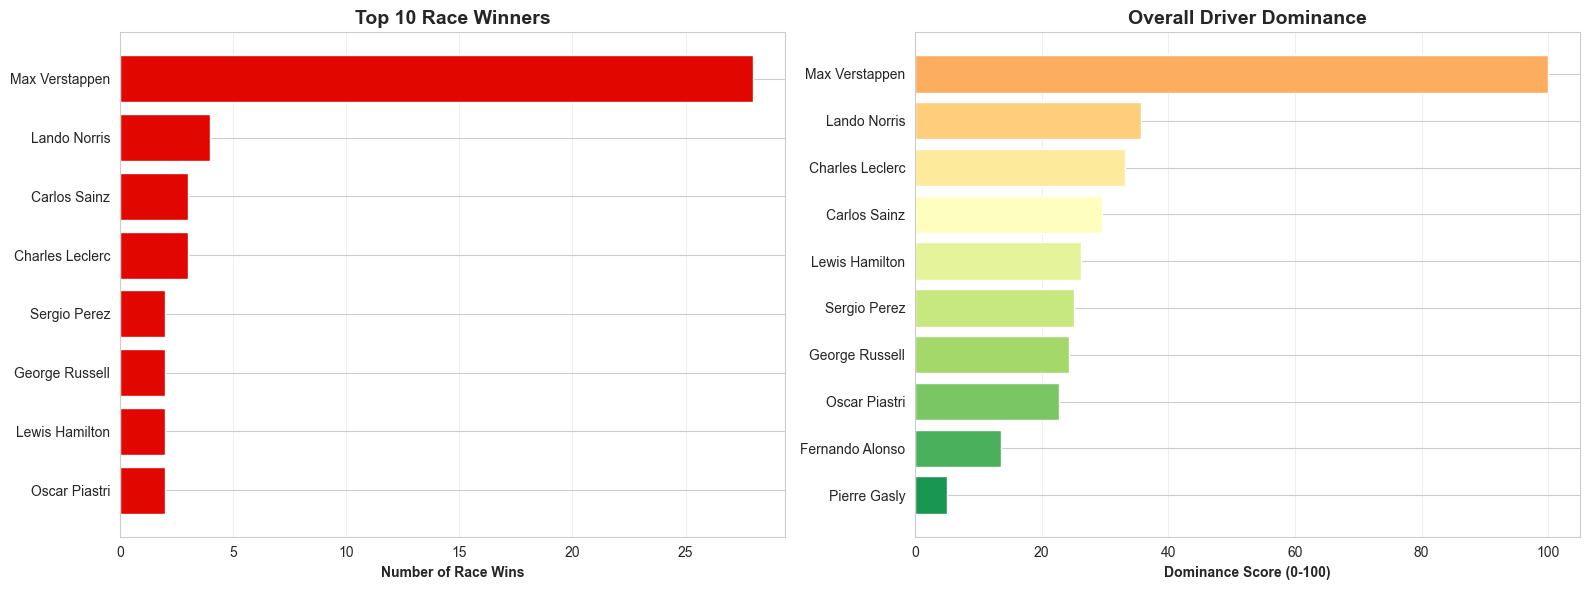


ANALYSIS 2: Constructor Performance

🏎️ Top 10 Constructor Performance:
                              total_pts  avg_pts  std_pts  avg_pos  seasons
team                                                                       
Red Bull Racing Honda RBPT       1449.0    724.5   191.63      2.0        2
Ferrari                          1058.0    529.0   173.95      2.5        2
McLaren Mercedes                  968.0    484.0   257.39      2.5        2
Mercedes                          877.0    438.5    41.72      3.0        2
Aston Martin Aramco Mercedes      374.0    187.0   131.52      5.0        2
Alpine Renault                    185.0     92.5    38.89      6.0        2
Haas Ferrari                       70.0     35.0    32.53      8.5        2
RB Honda RBPT                      46.0     46.0      NaN      8.0        1
Williams Mercedes                  45.0     22.5     7.78      8.0        2
AlphaTauri Honda RBPT              25.0     25.0      NaN      8.0        1


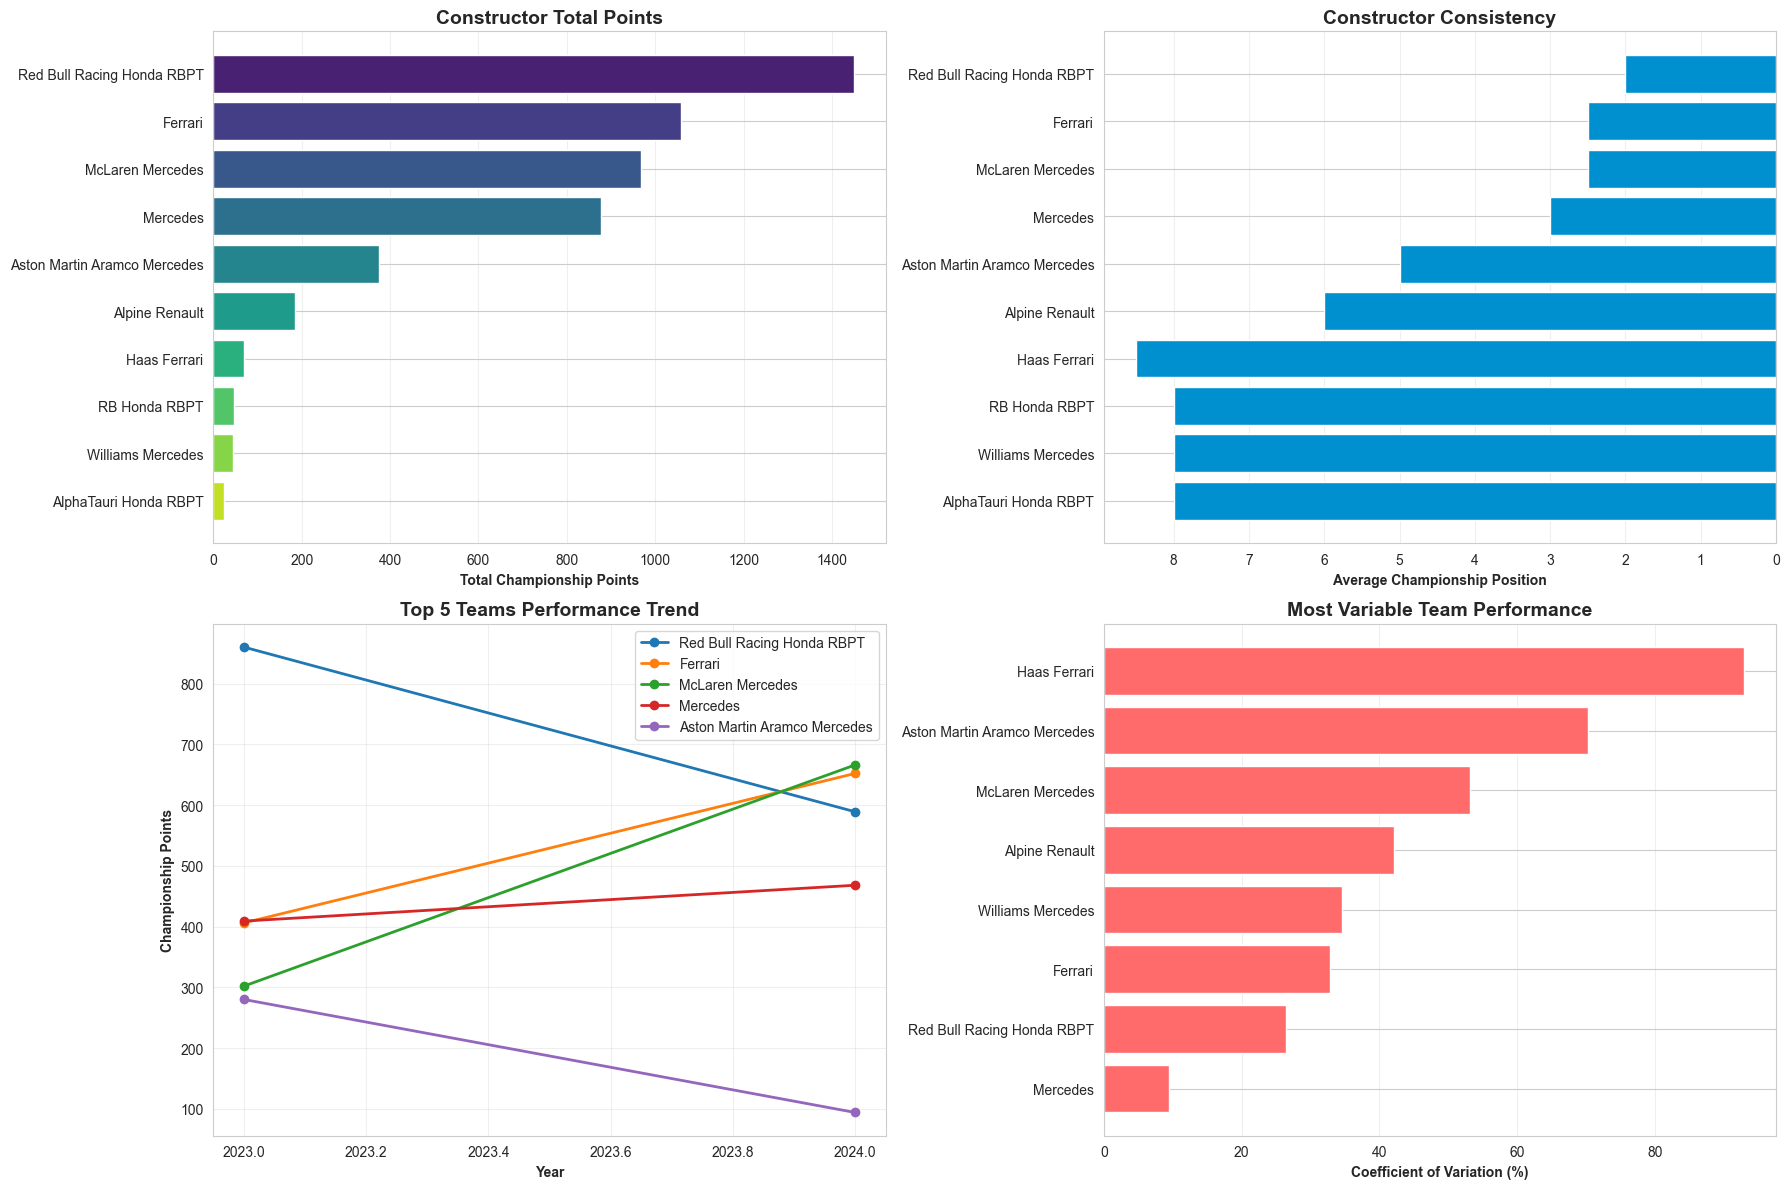


ANALYSIS 3: Championship Competitive Balance

⚖️ Championship Competitiveness by Year:
 year       champion  point_gap_1_2  top_3_concentration
 2023 Max Verstappen          290.0             44.50773
 2024 Max Verstappen           63.0             43.88868


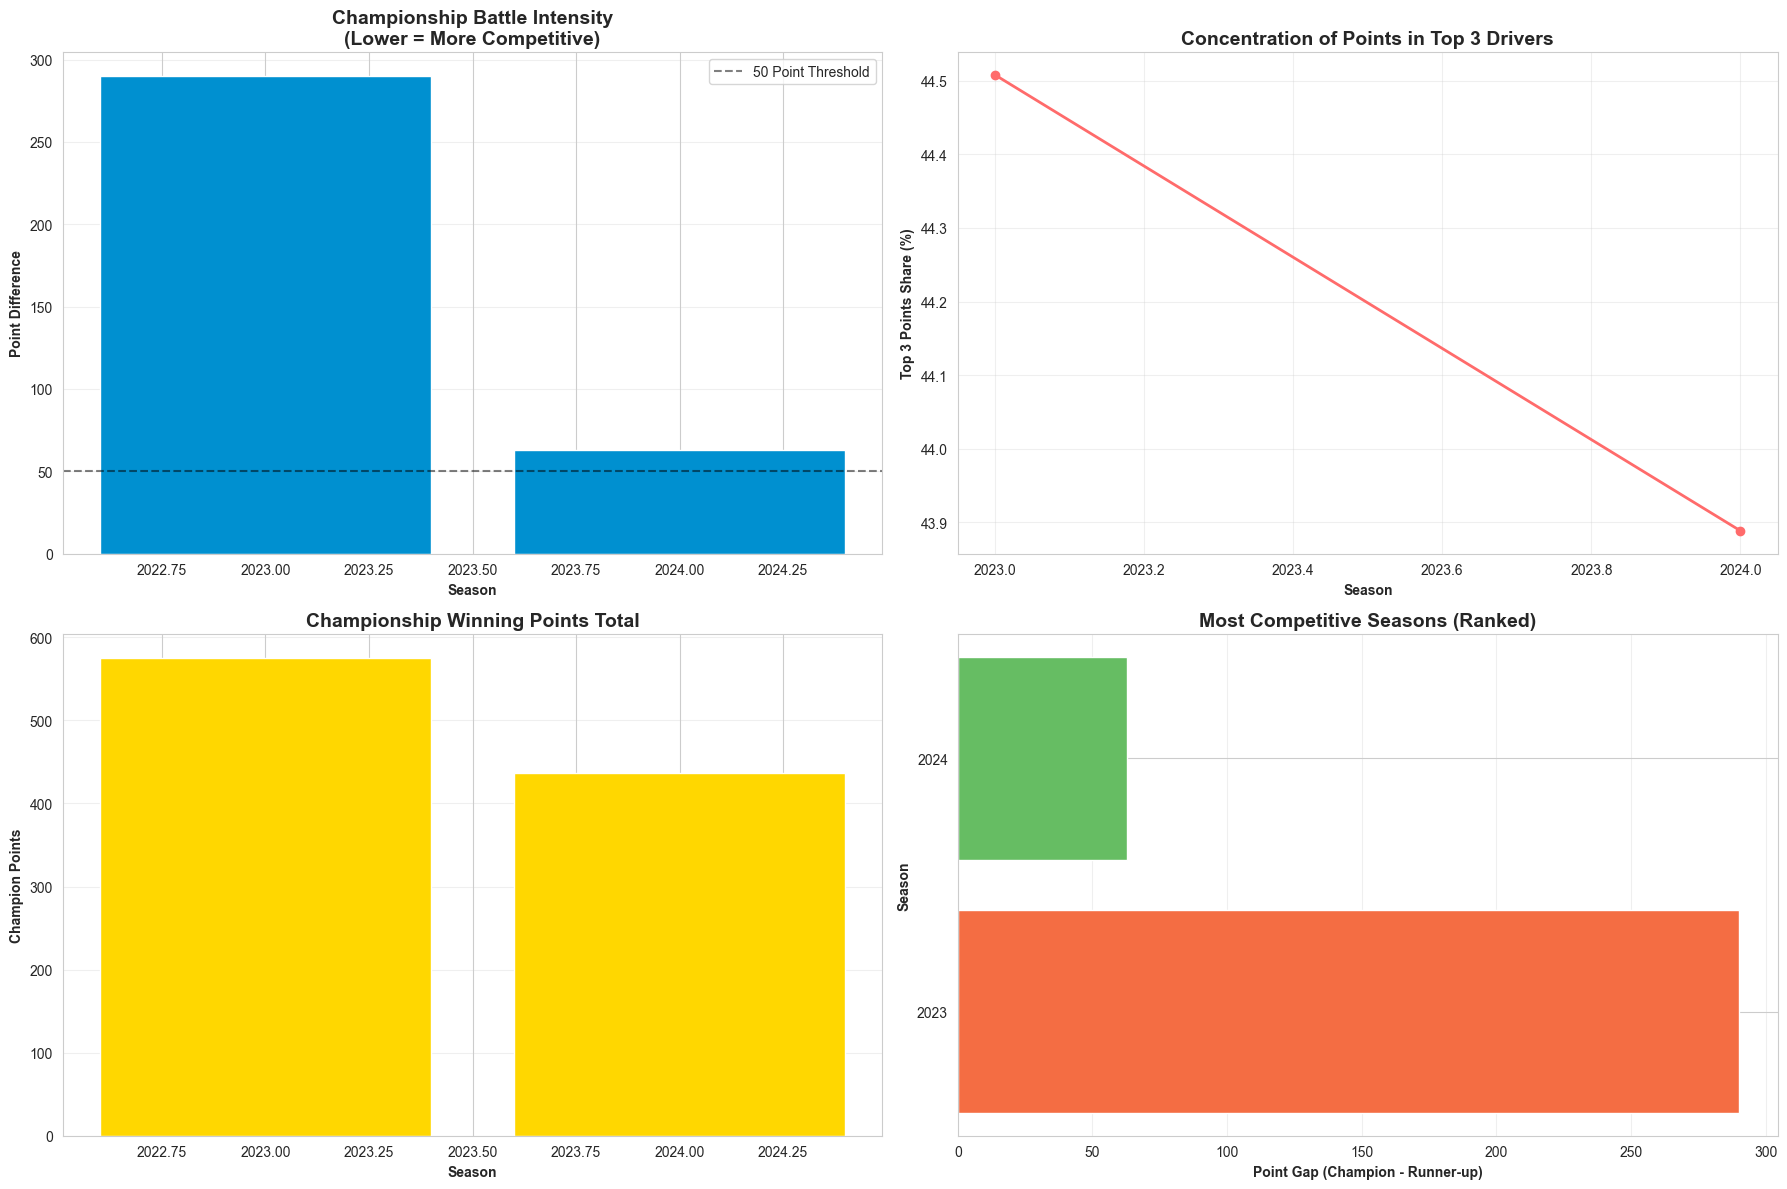


📊 Average point gap: 176.5 points
📊 Most competitive: 2024
📊 Least competitive: 2023

ANALYSIS 4: Performance Trends & Momentum

📈 Top 10 Rising Stars (Improving Performance):
         driver  trend_slope  total_growth  r_squared
  Oscar Piastri        195.0         195.0        1.0
   Lando Norris        169.0         169.0        1.0
Charles Leclerc        150.0         150.0        1.0
   Carlos Sainz         90.0          90.0        1.0
 George Russell         70.0          70.0        1.0
Nico Hulkenberg         32.0          32.0        1.0
Kevin Magnussen         13.0          13.0        1.0
   Yuki Tsunoda         13.0          13.0        1.0

📉 Declining Performance:
         driver  trend_slope  total_growth
 Max Verstappen       -138.0        -138.0
Fernando Alonso       -136.0        -136.0
   Sergio Perez       -133.0        -133.0
   Lance Stroll        -50.0         -50.0
   Esteban Ocon        -35.0         -35.0
   Pierre Gasly        -20.0         -20.0
Alexander 

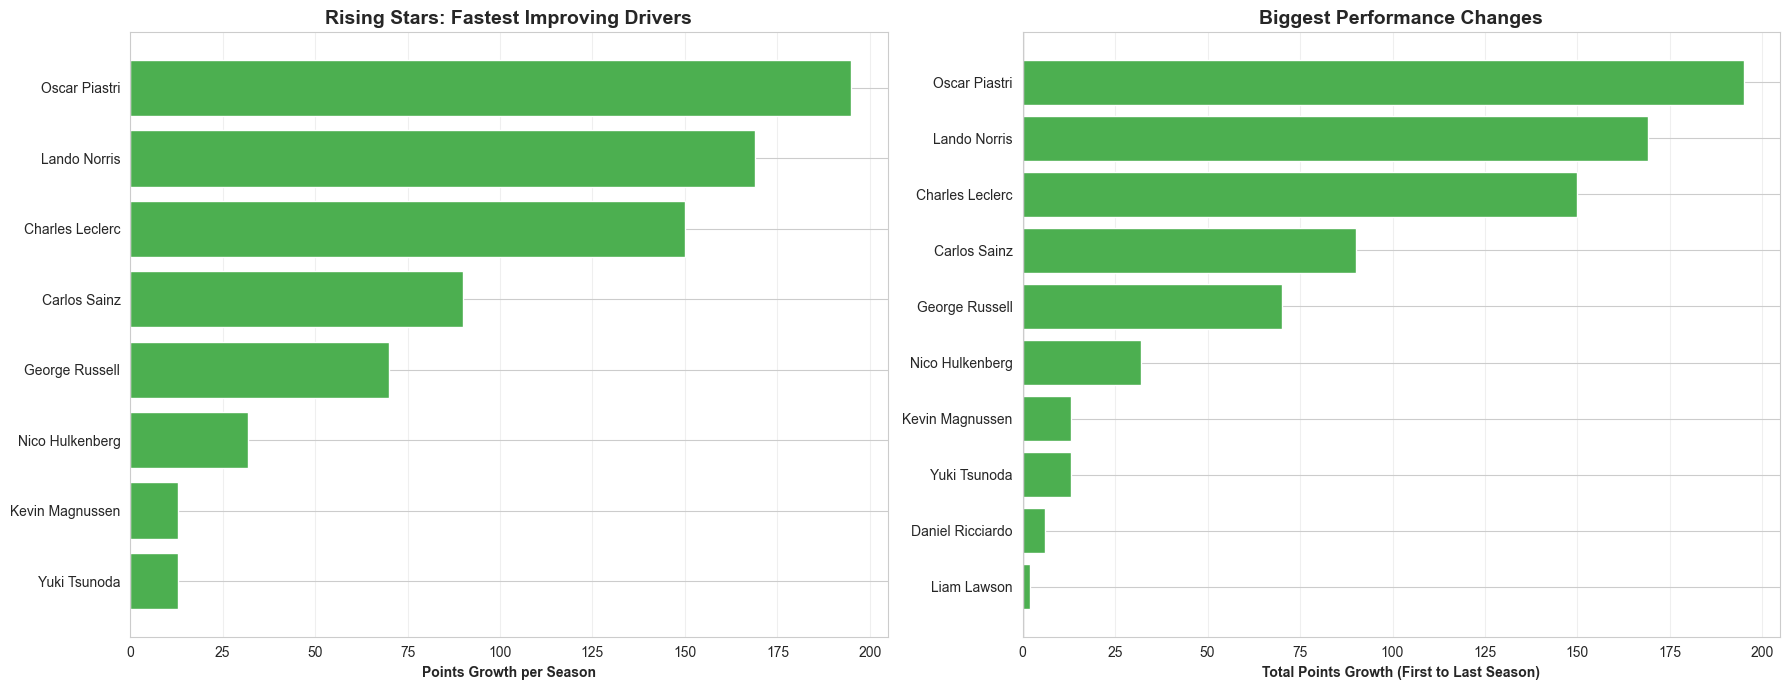


ANALYSIS 5: 2023 vs 2024 - Year-over-Year Comparison

👤 DRIVER PERFORMANCE CHANGES (2023 → 2024):

📈 Top 10 Most Improved Drivers:
          driver  2023_points  2024_points  points_change  position_change
   Oscar Piastri         97.0        292.0          195.0                5
    Lando Norris        205.0        374.0          169.0                4
 Charles Leclerc        206.0        356.0          150.0                2
    Carlos Sainz        200.0        290.0           90.0                2
  George Russell        175.0        245.0           70.0                2
 Nico Hulkenberg          9.0         41.0           32.0                5
    Yuki Tsunoda         17.0         30.0           13.0                2
 Kevin Magnussen          3.0         16.0           13.0                4
Daniel Ricciardo          6.0         12.0            6.0                0
     Liam Lawson          2.0          4.0            2.0               -1

📉 Bottom 10 Drivers (Declined Performance)

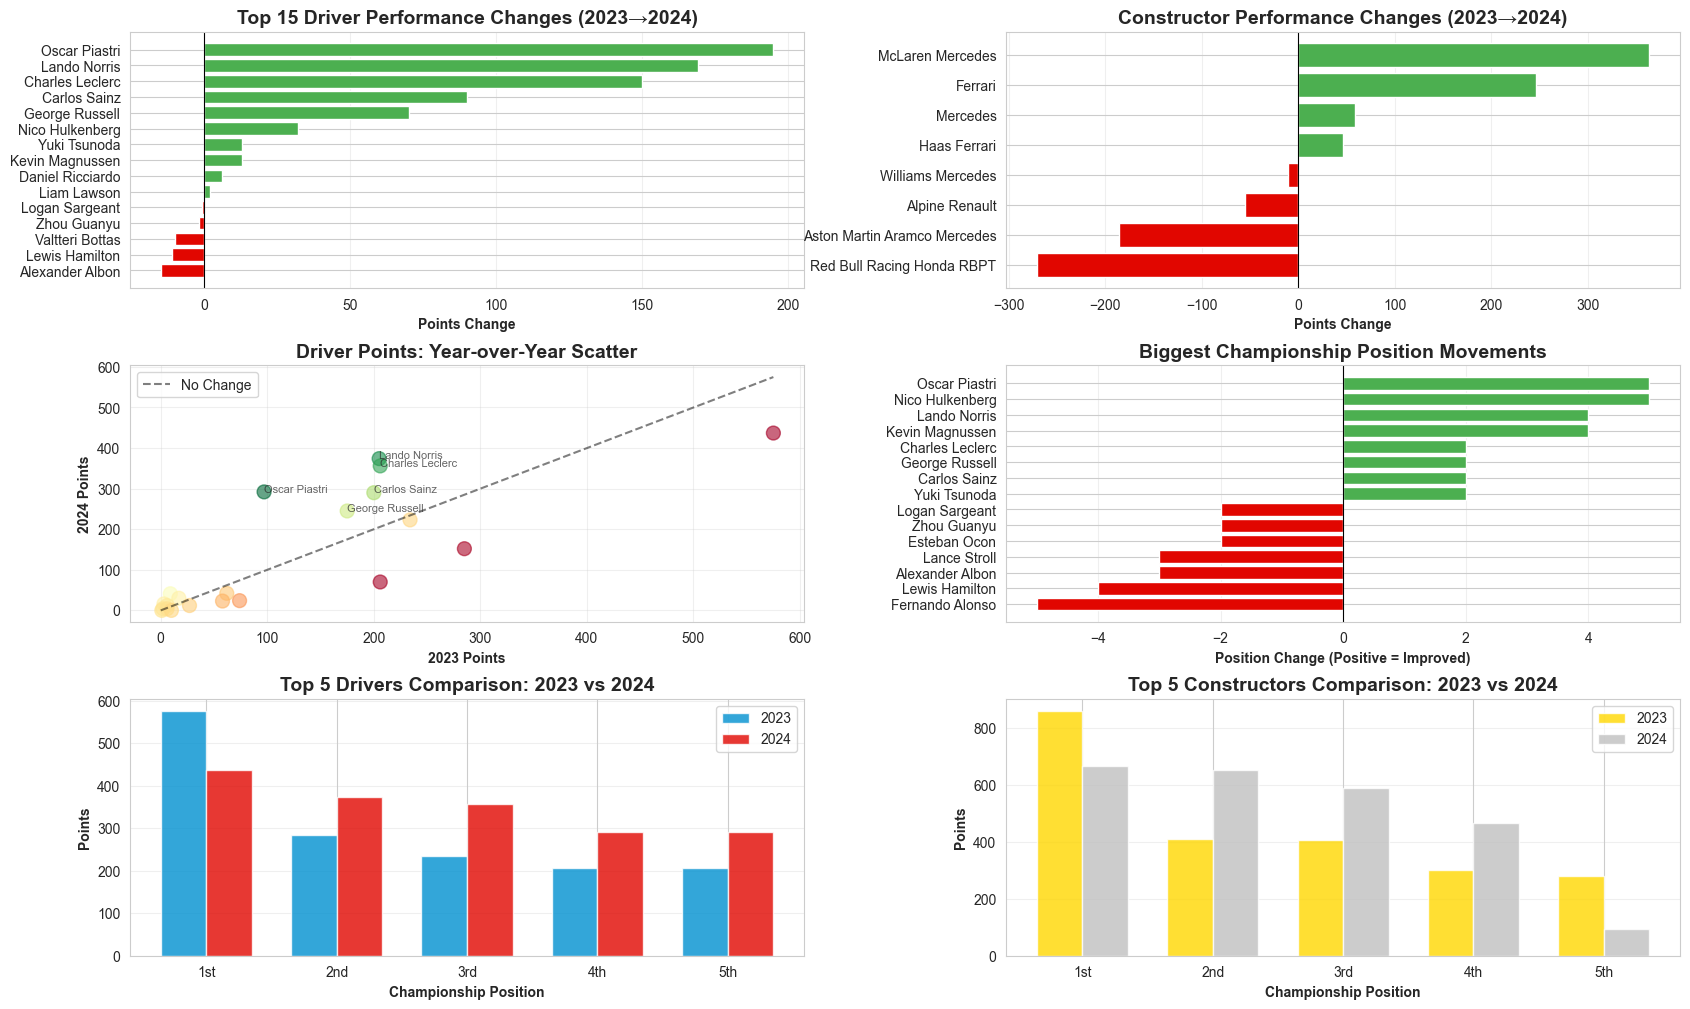


📊 STATISTICAL SUMMARY:
   Drivers analyzed: 21
   Drivers improved: 10
   Drivers declined: 11
   Average points change: 9.0 pts
   Biggest improvement: Oscar Piastri (+195.0 pts)
   Biggest decline: Max Verstappen (-138.0 pts)

EXECUTIVE SUMMARY: KEY INSIGHTS

📊 DATA COLLECTION SUMMARY
   Total Races: 46
   Driver Records: 46
   Constructor Records: 20
   Years Analyzed: 2
   Year Range: 2023 - 2024

🏆 DRIVER INSIGHTS
   Most Dominant: Max Verstappen (Score: 100.0/100)
   Total Race Wins: 28
   Most Wins Leader: Max Verstappen (28 victories)

🏎️ CONSTRUCTOR INSIGHTS
   Top Team: Red Bull Racing Honda RBPT (1449 total points)
   Most Consistent: Williams Mercedes

⚖️ COMPETITIVE BALANCE
   Average Championship Gap: 176.5 points
   Most Competitive Season: 2024 (63 pt gap)

📈 PERFORMANCE TRENDS
   Fastest Improving: Oscar Piastri
   Growth Rate: +195.0 pts/season


✓ Executive summary saved to: f1_executive_summary.txt

💾 Exporting DataFrames to CSV...
  ✓ Exported 46 race results to f

In [ ]:
class F1DataAnalyzer:
    """
    Comprehensive F1 Data Scraper with Integrated Analysis Engine.
    
    This class combines web scraping with immediate data analysis,
    demonstrating a complete data science pipeline from collection to insights.
    """
    
    def __init__(self, headless=False, wait_time=15):
        """Initialize scraper and analysis components."""
        self.base_url = "https://www.formula1.com"
        self.wait_time = wait_time
        
        # DataFrames to store scraped data
        self.df_races = pd.DataFrame()
        self.df_drivers = pd.DataFrame()
        self.df_constructors = pd.DataFrame()
        
        # Analysis results storage
        self.analysis_results = {}
        
        # Configure Chrome
        chrome_options = webdriver.ChromeOptions()
        if headless:
            chrome_options.add_argument('--headless=new')
        chrome_options.add_argument('--no-sandbox')
        chrome_options.add_argument('--disable-dev-shm-usage')
        chrome_options.add_argument('--disable-blink-features=AutomationControlled')
        chrome_options.add_argument('--window-size=1920,1080')
        chrome_options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36')
        
        # Initialize WebDriver
        service = Service(ChromeDriverManager().install())
        self.driver = webdriver.Chrome(service=service, options=chrome_options)
        self.wait = WebDriverWait(self.driver, wait_time)
        
        print("✓ F1 Data Analyzer initialized")
    
    def random_delay(self, min_seconds=2, max_seconds=4):
        """Add random delay."""
        time.sleep(random.uniform(min_seconds, max_seconds))
    
    def scroll_page(self):
        """Scroll to trigger lazy-loaded content."""
        self.driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(1)
        self.driver.execute_script("window.scrollTo(0, 0);")
        time.sleep(0.5)
    
    def wait_for_table_load(self, timeout=20):
        """Wait for table to load."""
        try:
            WebDriverWait(self.driver, timeout).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, "table tbody tr"))
            )
            time.sleep(2)
            return True
        except TimeoutException:
            return False
    
    def scrape_race_results(self, year=2024):
        """Scrape race results and store in DataFrame."""
        print(f"\n📊 Scraping {year} race results...")
        
        try:
            url = f"{self.base_url}/en/results/{year}/races"
            self.driver.get(url)
            self.random_delay(3, 5)
            self.scroll_page()
            
            if not self.wait_for_table_load():
                return pd.DataFrame()
            
            table = self.driver.find_element(By.CSS_SELECTOR, "table")
            rows = table.find_elements(By.TAG_NAME, "tr")
            
            data = []
            for idx, row in enumerate(rows[1:], 1):
                try:
                    cells = row.find_elements(By.TAG_NAME, "td")
                    if len(cells) >= 4:
                        cell_data = [cell.text.strip() for cell in cells]
                        
                        if cell_data[2]:  # Has winner
                            data.append({
                                'year': year,
                                'grand_prix': cell_data[0],
                                'date': cell_data[1],
                                'winner': cell_data[2],
                                'car': cell_data[3],
                                'laps': cell_data[4] if len(cell_data) > 4 else None,
                                'time': cell_data[5] if len(cell_data) > 5 else None
                            })
                except:
                    continue
            
            year_df = pd.DataFrame(data)
            self.df_races = pd.concat([self.df_races, year_df], ignore_index=True)
            print(f"✓ Scraped {len(data)} races")
            return year_df
            
        except Exception as e:
            print(f"❌ Error: {e}")
            return pd.DataFrame()
    
    def scrape_driver_standings(self, year=2024):
        """Scrape driver standings and store in DataFrame."""
        print(f"\n🏆 Scraping {year} driver standings...")
        
        try:
            url = f"{self.base_url}/en/results/{year}/drivers"
            self.driver.get(url)
            self.random_delay(3, 5)
            self.scroll_page()
            
            if not self.wait_for_table_load():
                return pd.DataFrame()
            
            table = self.driver.find_element(By.CSS_SELECTOR, "table")
            rows = table.find_elements(By.TAG_NAME, "tr")
            
            data = []
            for row in rows[1:]:
                try:
                    cells = row.find_elements(By.TAG_NAME, "td")
                    if len(cells) >= 4:
                        cell_data = [cell.text.strip() for cell in cells]
                        
                        if cell_data[1]:  # Has driver name
                            data.append({
                                'year': year,
                                'position': int(cell_data[0]) if cell_data[0].isdigit() else 0,
                                'driver': cell_data[1],
                                'nationality': cell_data[2],
                                'car': cell_data[3],
                                'points': float(cell_data[4]) if len(cell_data) > 4 else 0.0
                            })
                except:
                    continue
            
            year_df = pd.DataFrame(data)
            self.df_drivers = pd.concat([self.df_drivers, year_df], ignore_index=True)
            print(f"✓ Scraped {len(data)} driver records")
            return year_df
            
        except Exception as e:
            print(f"❌ Error: {e}")
            return pd.DataFrame()
    
    def scrape_constructor_standings(self, year=2024):
        """Scrape constructor standings and store in DataFrame."""
        print(f"\n🏎️ Scraping {year} constructor standings...")
        
        try:
            url = f"{self.base_url}/en/results/{year}/team"
            self.driver.get(url)
            self.random_delay(3, 5)
            self.scroll_page()
            
            if not self.wait_for_table_load():
                return pd.DataFrame()
            
            table = self.driver.find_element(By.CSS_SELECTOR, "table")
            rows = table.find_elements(By.TAG_NAME, "tr")
            
            data = []
            for row in rows[1:]:
                try:
                    cells = row.find_elements(By.TAG_NAME, "td")
                    if len(cells) >= 2:
                        cell_data = [cell.text.strip() for cell in cells]
                        
                        if cell_data[1]:  # Has team name
                            data.append({
                                'year': year,
                                'position': int(cell_data[0]) if cell_data[0].isdigit() else 0,
                                'team': cell_data[1],
                                'points': float(cell_data[2]) if len(cell_data) > 2 else 0.0
                            })
                except:
                    continue
            
            year_df = pd.DataFrame(data)
            self.df_constructors = pd.concat([self.df_constructors, year_df], ignore_index=True)
            print(f"✓ Scraped {len(data)} constructor records")
            return year_df
            
        except Exception as e:
            print(f"❌ Error: {e}")
            return pd.DataFrame()
    
    def scrape_multiple_seasons(self, start_year, end_year):
        """Scrape data for multiple seasons."""
        print(f"\n{'='*70}")
        print(f"SCRAPING F1 DATA: {start_year} - {end_year}")
        print(f"{'='*70}")
        
        for year in range(start_year, end_year + 1):
            print(f"\n--- Season {year} ---")
            self.scrape_race_results(year)
            self.random_delay(2, 3)
            self.scrape_driver_standings(year)
            self.random_delay(2, 3)
            self.scrape_constructor_standings(year)
            self.random_delay(2, 3)
        
        print(f"\n✅ Scraping complete!")
        print(f"   Races: {len(self.df_races)} records")
        print(f"   Drivers: {len(self.df_drivers)} records")
        print(f"   Constructors: {len(self.df_constructors)} records")
    
    # ========================================================================
    # ADVANCED DATA ANALYSIS METHODS
    # ========================================================================
    
    def analyze_driver_dominance(self):
        """Analyze driver dominance patterns."""
        print("\n" + "="*70)
        print("ANALYSIS 1: Driver Dominance")
        print("="*70)
        
        # Race wins analysis
        race_wins = self.df_races['winner'].value_counts().head(10)
        
        # Championship points analysis
        driver_points = self.df_drivers.groupby('driver')['points'].agg(['sum', 'mean', 'max'])
        driver_points = driver_points.sort_values('sum', ascending=False).head(10)
        
        # Calculate dominance score (wins + normalized points)
        dominance = pd.DataFrame({
            'wins': race_wins,
            'total_points': driver_points['sum']
        }).fillna(0)
        
        dominance['dominance_score'] = (
            (dominance['wins'] / dominance['wins'].max()) * 0.5 +
            (dominance['total_points'] / dominance['total_points'].max()) * 0.5
        ) * 100
        
        dominance = dominance.sort_values('dominance_score', ascending=False)
        
        print("\n🏆 Top 10 Most Dominant Drivers:")
        print(dominance.head(10).to_string())
        
        # Visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot 1: Race Wins
        top_winners = race_wins.head(10)
        ax1.barh(range(len(top_winners)), top_winners.values, color='#E10600')
        ax1.set_yticks(range(len(top_winners)))
        ax1.set_yticklabels(top_winners.index)
        ax1.set_xlabel('Number of Race Wins', fontweight='bold')
        ax1.set_title('Top 10 Race Winners', fontsize=14, fontweight='bold')
        ax1.invert_yaxis()
        ax1.grid(axis='x', alpha=0.3)
        
        # Plot 2: Dominance Score
        top_dom = dominance.head(10)
        colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(top_dom)))
        ax2.barh(range(len(top_dom)), top_dom['dominance_score'], color=colors)
        ax2.set_yticks(range(len(top_dom)))
        ax2.set_yticklabels(top_dom.index)
        ax2.set_xlabel('Dominance Score (0-100)', fontweight='bold')
        ax2.set_title('Overall Driver Dominance', fontsize=14, fontweight='bold')
        ax2.invert_yaxis()
        ax2.grid(axis='x', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('driver_dominance_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        self.analysis_results['driver_dominance'] = dominance
        return dominance
    
    def analyze_constructor_performance(self):
        """Analyze constructor/team performance."""
        print("\n" + "="*70)
        print("ANALYSIS 2: Constructor Performance")
        print("="*70)
        
        # Team performance by year
        team_yearly = self.df_constructors.pivot_table(
            index='team',
            columns='year',
            values='points',
            aggfunc='sum'
        ).fillna(0)
        
        # Overall statistics
        team_stats = self.df_constructors.groupby('team').agg({
            'points': ['sum', 'mean', 'std'],
            'position': 'mean',
            'year': 'count'
        }).round(2)
        
        team_stats.columns = ['total_pts', 'avg_pts', 'std_pts', 'avg_pos', 'seasons']
        team_stats = team_stats.sort_values('total_pts', ascending=False).head(10)
        
        print("\n🏎️ Top 10 Constructor Performance:")
        print(team_stats.to_string())
        
        # Visualization
        fig, axes = plt.subplots(2, 2, figsize=(18, 12))
        
        # Plot 1: Total Points Bar Chart
        ax1 = axes[0, 0]
        top_teams = team_stats.head(10)
        colors = sns.color_palette('viridis', len(top_teams))
        ax1.barh(range(len(top_teams)), top_teams['total_pts'], color=colors)
        ax1.set_yticks(range(len(top_teams)))
        ax1.set_yticklabels(top_teams.index)
        ax1.set_xlabel('Total Championship Points', fontweight='bold')
        ax1.set_title('Constructor Total Points', fontsize=14, fontweight='bold')
        ax1.invert_yaxis()
        ax1.grid(axis='x', alpha=0.3)
        
        # Plot 2: Average Position
        ax2 = axes[0, 1]
        ax2.barh(range(len(top_teams)), top_teams['avg_pos'], color='#0090D0')
        ax2.set_yticks(range(len(top_teams)))
        ax2.set_yticklabels(top_teams.index)
        ax2.set_xlabel('Average Championship Position', fontweight='bold')
        ax2.set_title('Constructor Consistency', fontsize=14, fontweight='bold')
        ax2.invert_yaxis()
        ax2.invert_xaxis()  # Lower position is better
        ax2.grid(axis='x', alpha=0.3)
        
        # Plot 3: Points Trend Over Years
        ax3 = axes[1, 0]
        top_5_teams = team_stats.head(5).index
        for team in top_5_teams:
            if team in team_yearly.index:
                ax3.plot(team_yearly.columns, team_yearly.loc[team], 
                        marker='o', linewidth=2, label=team)
        ax3.set_xlabel('Year', fontweight='bold')
        ax3.set_ylabel('Championship Points', fontweight='bold')
        ax3.set_title('Top 5 Teams Performance Trend', fontsize=14, fontweight='bold')
        ax3.legend(loc='best')
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Consistency (Points Std Dev)
        ax4 = axes[1, 1]
        consistency = team_stats[team_stats['seasons'] >= 2].copy()
        consistency['cv'] = (consistency['std_pts'] / consistency['avg_pts']) * 100
        consistency = consistency.nlargest(10, 'cv')
        ax4.barh(range(len(consistency)), consistency['cv'], color='#FF6B6B')
        ax4.set_yticks(range(len(consistency)))
        ax4.set_yticklabels(consistency.index)
        ax4.set_xlabel('Coefficient of Variation (%)', fontweight='bold')
        ax4.set_title('Most Variable Team Performance', fontsize=14, fontweight='bold')
        ax4.invert_yaxis()
        ax4.grid(axis='x', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('constructor_performance_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        self.analysis_results['constructor_performance'] = team_stats
        return team_stats
    
    def analyze_competitive_balance(self):
        """Analyze championship competitiveness."""
        print("\n" + "="*70)
        print("ANALYSIS 3: Championship Competitive Balance")
        print("="*70)
        
        balance_data = []
        
        for year in self.df_drivers['year'].unique():
            year_data = self.df_drivers[self.df_drivers['year'] == year].sort_values('points', ascending=False)
            
            if len(year_data) >= 2:
                top_3 = year_data.head(3)
                all_points = year_data['points'].sum()
                
                balance_data.append({
                    'year': year,
                    'champion': top_3.iloc[0]['driver'],
                    'champion_pts': top_3.iloc[0]['points'],
                    'runner_up_pts': top_3.iloc[1]['points'],
                    'third_place_pts': top_3.iloc[2]['points'],
                    'point_gap_1_2': top_3.iloc[0]['points'] - top_3.iloc[1]['points'],
                    'point_gap_2_3': top_3.iloc[1]['points'] - top_3.iloc[2]['points'],
                    'top_3_concentration': (top_3['points'].sum() / all_points) * 100,
                    'total_drivers': len(year_data)
                })
        
        df_balance = pd.DataFrame(balance_data)
        print("Competitive Balance by Season:")
        # Plot 4: Competitive Seasons Ranking
        ax4 = axes[1, 1]
        df_balance_sorted = df_balance.sort_values('point_gap_1_2')
        colors_comp = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(df_balance_sorted)))
        ax4.barh(range(len(df_balance_sorted)), df_balance_sorted['point_gap_1_2'], color=colors_comp)
        ax4.set_yticks(range(len(df_balance_sorted)))
        ax4.set_yticklabels([f"{int(y)}" for y in df_balance_sorted['year']])
        ax4.set_xlabel('Point Gap (Champion - Runner-up)', fontweight='bold')
        ax4.set_ylabel('Season', fontweight='bold')
        ax4.set_title('Most Competitive Seasons (Ranked)', fontsize=14, fontweight='bold')
        ax4.invert_yaxis()
        ax4.grid(axis='x', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('competitive_balance_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"\n📊 Average point gap: {df_balance['point_gap_1_2'].mean():.1f} points")
        print(f"📊 Most competitive: {df_balance.loc[df_balance['point_gap_1_2'].idxmin(), 'year']}")
        print(f"📊 Least competitive: {df_balance.loc[df_balance['point_gap_1_2'].idxmax(), 'year']}")
        
        self.analysis_results['competitive_balance'] = df_balance
        return df_balance
    
    def analyze_performance_trends(self):
        """Analyze performance trends and momentum."""
        print("\n" + "="*70)
        print("ANALYSIS 4: Performance Trends & Momentum")
        print("="*70)
        
        # Driver performance trends
        driver_trends = self.df_drivers.groupby(['year', 'driver'])['points'].sum().reset_index()
        driver_pivot = driver_trends.pivot(index='driver', columns='year', values='points')
        
        # Calculate year-over-year growth
        trends_data = []
        for driver in driver_pivot.index:
            driver_years = driver_pivot.loc[driver].dropna()
            if len(driver_years) >= 2:
                # Calculate linear trend
                years = driver_years.index.values
                points = driver_years.values
                slope, intercept, r_value, _, _ = stats.linregress(years, points)
                
                trends_data.append({
                    'driver': driver,
                    'seasons': len(driver_years),
                    'avg_points': driver_years.mean(),
                    'trend_slope': slope,
                    'r_squared': r_value**2,
                    'first_season_pts': driver_years.iloc[0],
                    'last_season_pts': driver_years.iloc[-1],
                    'total_growth': driver_years.iloc[-1] - driver_years.iloc[0]
                })
        
        df_trends = pd.DataFrame(trends_data)
        
        # Rising stars (positive trend, at least 2 seasons)
        rising = df_trends[df_trends['trend_slope'] > 10].sort_values('trend_slope', ascending=False).head(10)
        
        # Declining (negative trend)
        declining = df_trends[df_trends['trend_slope'] < -10].sort_values('trend_slope').head(10)
        
        print("\n📈 Top 10 Rising Stars (Improving Performance):")
        print(rising[['driver', 'trend_slope', 'total_growth', 'r_squared']].to_string(index=False))
        
        if len(declining) > 0:
            print("\n📉 Declining Performance:")
            print(declining[['driver', 'trend_slope', 'total_growth']].to_string(index=False))
        
        # Visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
        
        # Plot 1: Rising Stars
        if len(rising) > 0:
            ax1.barh(range(len(rising)), rising['trend_slope'], color='#4CAF50')
            ax1.set_yticks(range(len(rising)))
            ax1.set_yticklabels(rising['driver'])
            ax1.set_xlabel('Points Growth per Season', fontweight='bold')
            ax1.set_title('Rising Stars: Fastest Improving Drivers', fontsize=14, fontweight='bold')
            ax1.invert_yaxis()
            ax1.grid(axis='x', alpha=0.3)
        
        # Plot 2: Total Growth
        top_growth = df_trends.nlargest(10, 'total_growth')
        colors_growth = ['#4CAF50' if x > 0 else '#E10600' for x in top_growth['total_growth']]
        ax2.barh(range(len(top_growth)), top_growth['total_growth'], color=colors_growth)
        ax2.set_yticks(range(len(top_growth)))
        ax2.set_yticklabels(top_growth['driver'])
        ax2.set_xlabel('Total Points Growth (First to Last Season)', fontweight='bold')
        ax2.set_title('Biggest Performance Changes', fontsize=14, fontweight='bold')
        ax2.invert_yaxis()
        ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
        ax2.grid(axis='x', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('performance_trends_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        self.analysis_results['performance_trends'] = df_trends
        return df_trends
    
    def analyze_year_over_year_comparison(self, year1=2023, year2=2024):
        """
        Compare two seasons head-to-head with advanced metrics.
        
        Args:
            year1: First year to compare
            year2: Second year to compare
        """
        print("\n" + "="*70)
        print(f"ANALYSIS 5: {year1} vs {year2} - Year-over-Year Comparison")
        print("="*70)
        
        # Filter data for both years
        df_y1_drivers = self.df_drivers[self.df_drivers['year'] == year1]
        df_y2_drivers = self.df_drivers[self.df_drivers['year'] == year2]
        df_y1_teams = self.df_constructors[self.df_constructors['year'] == year1]
        df_y2_teams = self.df_constructors[self.df_constructors['year'] == year2]
        
        # Driver comparison
        print(f"\n👤 DRIVER PERFORMANCE CHANGES ({year1} → {year2}):")
        
        # Find common drivers
        common_drivers = set(df_y1_drivers['driver']) & set(df_y2_drivers['driver'])
        
        driver_changes = []
        for driver in common_drivers:
            pts_y1 = df_y1_drivers[df_y1_drivers['driver'] == driver]['points'].values[0]
            pts_y2 = df_y2_drivers[df_y2_drivers['driver'] == driver]['points'].values[0]
            pos_y1 = df_y1_drivers[df_y1_drivers['driver'] == driver]['position'].values[0]
            pos_y2 = df_y2_drivers[df_y2_drivers['driver'] == driver]['position'].values[0]
            
            driver_changes.append({
                'driver': driver,
                f'{year1}_points': pts_y1,
                f'{year2}_points': pts_y2,
                'points_change': pts_y2 - pts_y1,
                'points_change_pct': ((pts_y2 - pts_y1) / pts_y1 * 100) if pts_y1 > 0 else 0,
                f'{year1}_position': pos_y1,
                f'{year2}_position': pos_y2,
                'position_change': pos_y1 - pos_y2  # Negative = improved
            })
        
        df_driver_changes = pd.DataFrame(driver_changes)
        df_driver_changes = df_driver_changes.sort_values('points_change', ascending=False)
        
        # Top improvers and decliners
        top_improvers = df_driver_changes.head(10)
        top_decliners = df_driver_changes.tail(10)
        
        print("\n📈 Top 10 Most Improved Drivers:")
        print(top_improvers[['driver', f'{year1}_points', f'{year2}_points', 'points_change', 'position_change']].to_string(index=False))
        
        print("\n📉 Bottom 10 Drivers (Declined Performance):")
        print(top_decliners[['driver', f'{year1}_points', f'{year2}_points', 'points_change', 'position_change']].to_string(index=False))
        
        # Constructor comparison
        print(f"\n🏎️ CONSTRUCTOR PERFORMANCE CHANGES ({year1} → {year2}):")
        
        common_teams = set(df_y1_teams['team']) & set(df_y2_teams['team'])
        
        team_changes = []
        for team in common_teams:
            pts_y1 = df_y1_teams[df_y1_teams['team'] == team]['points'].values[0]
            pts_y2 = df_y2_teams[df_y2_teams['team'] == team]['points'].values[0]
            
            team_changes.append({
                'team': team,
                f'{year1}_points': pts_y1,
                f'{year2}_points': pts_y2,
                'points_change': pts_y2 - pts_y1,
                'points_change_pct': ((pts_y2 - pts_y1) / pts_y1 * 100) if pts_y1 > 0 else 0
            })
        
        df_team_changes = pd.DataFrame(team_changes)
        df_team_changes = df_team_changes.sort_values('points_change', ascending=False)
        
        print("\n" + df_team_changes[['team', f'{year1}_points', f'{year2}_points', 'points_change', 'points_change_pct']].to_string(index=False))
        
        # Visualization
        fig = plt.figure(figsize=(20, 12))
        gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
        
        # Plot 1: Driver Points Change (Top 15)
        ax1 = fig.add_subplot(gs[0, 0])
        top_15_changes = df_driver_changes.head(15)
        colors_drivers = ['#4CAF50' if x > 0 else '#E10600' for x in top_15_changes['points_change']]
        ax1.barh(range(len(top_15_changes)), top_15_changes['points_change'], color=colors_drivers)
        ax1.set_yticks(range(len(top_15_changes)))
        ax1.set_yticklabels(top_15_changes['driver'])
        ax1.set_xlabel('Points Change', fontweight='bold')
        ax1.set_title(f'Top 15 Driver Performance Changes ({year1}→{year2})', fontsize=14, fontweight='bold')
        ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
        ax1.invert_yaxis()
        ax1.grid(axis='x', alpha=0.3)
        
        # Plot 2: Constructor Points Change
        ax2 = fig.add_subplot(gs[0, 1])
        colors_teams = ['#4CAF50' if x > 0 else '#E10600' for x in df_team_changes['points_change']]
        ax2.barh(range(len(df_team_changes)), df_team_changes['points_change'], color=colors_teams)
        ax2.set_yticks(range(len(df_team_changes)))
        ax2.set_yticklabels(df_team_changes['team'])
        ax2.set_xlabel('Points Change', fontweight='bold')
        ax2.set_title(f'Constructor Performance Changes ({year1}→{year2})', fontsize=14, fontweight='bold')
        ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
        ax2.invert_yaxis()
        ax2.grid(axis='x', alpha=0.3)
        
        # Plot 3: Points Distribution Comparison (Drivers)
        ax3 = fig.add_subplot(gs[1, 0])
        ax3.scatter(df_driver_changes[f'{year1}_points'], df_driver_changes[f'{year2}_points'], 
                   s=100, alpha=0.6, c=df_driver_changes['points_change'], cmap='RdYlGn')
        
        # Add diagonal line (no change)
        max_pts = max(df_driver_changes[f'{year1}_points'].max(), df_driver_changes[f'{year2}_points'].max())
        ax3.plot([0, max_pts], [0, max_pts], 'k--', alpha=0.5, label='No Change')
        
        ax3.set_xlabel(f'{year1} Points', fontweight='bold')
        ax3.set_ylabel(f'{year2} Points', fontweight='bold')
        ax3.set_title('Driver Points: Year-over-Year Scatter', fontsize=14, fontweight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Annotate top movers
        for _, row in df_driver_changes.head(5).iterrows():
            ax3.annotate(row['driver'], 
                        (row[f'{year1}_points'], row[f'{year2}_points']),
                        fontsize=8, alpha=0.7)
        
        # Plot 4: Position Changes (Top drivers who changed position significantly)
        ax4 = fig.add_subplot(gs[1, 1])
        sig_position_changes = df_driver_changes[df_driver_changes['position_change'].abs() >= 2].copy()
        sig_position_changes = sig_position_changes.sort_values('position_change', ascending=False).head(15)
        
        colors_pos = ['#4CAF50' if x > 0 else '#E10600' for x in sig_position_changes['position_change']]
        ax4.barh(range(len(sig_position_changes)), sig_position_changes['position_change'], color=colors_pos)
        ax4.set_yticks(range(len(sig_position_changes)))
        ax4.set_yticklabels(sig_position_changes['driver'])
        ax4.set_xlabel('Position Change (Positive = Improved)', fontweight='bold')
        ax4.set_title('Biggest Championship Position Movements', fontsize=14, fontweight='bold')
        ax4.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
        ax4.invert_yaxis()
        ax4.grid(axis='x', alpha=0.3)
        
        # Plot 5: Champion Comparison
        ax5 = fig.add_subplot(gs[2, 0])
        top_5_y1 = df_y1_drivers.nsmallest(5, 'position')
        top_5_y2 = df_y2_drivers.nsmallest(5, 'position')
        
        x_pos = np.arange(5)
        width = 0.35
        
        ax5.bar(x_pos - width/2, top_5_y1['points'].values, width, label=str(year1), color='#0090D0', alpha=0.8)
        ax5.bar(x_pos + width/2, top_5_y2['points'].values, width, label=str(year2), color='#E10600', alpha=0.8)
        
        ax5.set_xlabel('Championship Position', fontweight='bold')
        ax5.set_ylabel('Points', fontweight='bold')
        ax5.set_title(f'Top 5 Drivers Comparison: {year1} vs {year2}', fontsize=14, fontweight='bold')
        ax5.set_xticks(x_pos)
        ax5.set_xticklabels(['1st', '2nd', '3rd', '4th', '5th'])
        ax5.legend()
        ax5.grid(axis='y', alpha=0.3)
        
        # Plot 6: Constructor Comparison (Top 5)
        ax6 = fig.add_subplot(gs[2, 1])
        top_5_teams_y1 = df_y1_teams.nsmallest(5, 'position')
        top_5_teams_y2 = df_y2_teams.nsmallest(5, 'position')
        
        x_pos_teams = np.arange(5)
        
        ax6.bar(x_pos_teams - width/2, top_5_teams_y1['points'].values, width, 
               label=str(year1), color='#FFD700', alpha=0.8)
        ax6.bar(x_pos_teams + width/2, top_5_teams_y2['points'].values, width, 
               label=str(year2), color='#C0C0C0', alpha=0.8)
        
        ax6.set_xlabel('Championship Position', fontweight='bold')
        ax6.set_ylabel('Points', fontweight='bold')
        ax6.set_title(f'Top 5 Constructors Comparison: {year1} vs {year2}', fontsize=14, fontweight='bold')
        ax6.set_xticks(x_pos_teams)
        ax6.set_xticklabels(['1st', '2nd', '3rd', '4th', '5th'])
        ax6.legend()
        ax6.grid(axis='y', alpha=0.3)
        
        plt.savefig(f'year_comparison_{year1}_vs_{year2}.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Statistical summary
        print(f"\n📊 STATISTICAL SUMMARY:")
        print(f"   Drivers analyzed: {len(common_drivers)}")
        print(f"   Drivers improved: {len(df_driver_changes[df_driver_changes['points_change'] > 0])}")
        print(f"   Drivers declined: {len(df_driver_changes[df_driver_changes['points_change'] < 0])}")
        print(f"   Average points change: {df_driver_changes['points_change'].mean():.1f} pts")
        print(f"   Biggest improvement: {df_driver_changes.iloc[0]['driver']} (+{df_driver_changes.iloc[0]['points_change']:.1f} pts)")
        print(f"   Biggest decline: {df_driver_changes.iloc[-1]['driver']} ({df_driver_changes.iloc[-1]['points_change']:.1f} pts)")
        
        self.analysis_results['year_comparison'] = {
            'driver_changes': df_driver_changes,
            'team_changes': df_team_changes
        }
        
        return df_driver_changes, df_team_changes
    
    def generate_executive_summary(self):
        """Generate comprehensive executive summary."""
        print("\n" + "="*70)
        print("EXECUTIVE SUMMARY: KEY INSIGHTS")
        print("="*70)
        
        summary = f"""
📊 DATA COLLECTION SUMMARY
   Total Races: {len(self.df_races)}
   Driver Records: {len(self.df_drivers)}
   Constructor Records: {len(self.df_constructors)}
   Years Analyzed: {self.df_drivers['year'].nunique()}
   Year Range: {int(self.df_drivers['year'].min())} - {int(self.df_drivers['year'].max())}

🏆 DRIVER INSIGHTS
"""
        
        if 'driver_dominance' in self.analysis_results:
            dom = self.analysis_results['driver_dominance']
            summary += f"   Most Dominant: {dom.index[0]} (Score: {dom.iloc[0]['dominance_score']:.1f}/100)\n"
            summary += f"   Total Race Wins: {int(dom.iloc[0]['wins'])}\n"
        
        if len(self.df_races) > 0:
            most_wins = self.df_races['winner'].value_counts().iloc[0]
            winner_name = self.df_races['winner'].value_counts().index[0]
            summary += f"   Most Wins Leader: {winner_name} ({int(most_wins)} victories)\n"
        
        summary += f"\n🏎️ CONSTRUCTOR INSIGHTS\n"
        
        if 'constructor_performance' in self.analysis_results:
            const = self.analysis_results['constructor_performance']
            summary += f"   Top Team: {const.index[0]} ({const.iloc[0]['total_pts']:.0f} total points)\n"
            summary += f"   Most Consistent: {const.nsmallest(1, 'std_pts').index[0]}\n"
        
        summary += f"\n⚖️ COMPETITIVE BALANCE\n"
        
        if 'competitive_balance' in self.analysis_results:
            balance = self.analysis_results['competitive_balance']
            avg_gap = balance['point_gap_1_2'].mean()
            most_comp = balance.loc[balance['point_gap_1_2'].idxmin()]
            summary += f"   Average Championship Gap: {avg_gap:.1f} points\n"
            summary += f"   Most Competitive Season: {int(most_comp['year'])} ({most_comp['point_gap_1_2']:.0f} pt gap)\n"
        
        summary += f"\n📈 PERFORMANCE TRENDS\n"
        
        if 'performance_trends' in self.analysis_results:
            trends = self.analysis_results['performance_trends']
            top_improver = trends.nlargest(1, 'trend_slope')
            if len(top_improver) > 0:
                summary += f"   Fastest Improving: {top_improver.iloc[0]['driver']}\n"
                summary += f"   Growth Rate: +{top_improver.iloc[0]['trend_slope']:.1f} pts/season\n"
        
        print(summary)
        
        # Save summary to file with UTF-8 encoding
        try:
            with open('f1_executive_summary.txt', 'w', encoding='utf-8') as f:
                f.write(summary)
            print("\n✓ Executive summary saved to: f1_executive_summary.txt")
        except Exception as e:
            print(f"\n⚠ Could not save summary to file: {e}")
            print("   Summary is displayed above and available in memory")
        
        return summary
    
    def export_to_csv(self, suffix=''):
        """
        Export DataFrames to CSV with error handling.
        
        Args:
            suffix: Optional suffix to add to filenames (e.g., timestamp)
        """
        print("\n💾 Exporting DataFrames to CSV...")
        
        if suffix:
            suffix = f"_{suffix}"
        
        csv_files = [
            (self.df_races, f'f1_race_results{suffix}.csv', 'race results'),
            (self.df_drivers, f'f1_driver_standings{suffix}.csv', 'driver standings'),
            (self.df_constructors, f'f1_constructor_standings{suffix}.csv', 'constructor standings')
        ]
        
        exported = []
        failed = []
        
        for df, filename, name in csv_files:
            if not df.empty:
                try:
                    df.to_csv(filename, index=False)
                    print(f"  ✓ Exported {len(df)} {name} to {filename}")
                    exported.append(filename)
                except PermissionError:
                    print(f"  ⚠ Could not export {filename} - file is open in another program")
                    print(f"     Close the file and try again, or use a different filename")
                    failed.append(filename)
                except Exception as e:
                    print(f"  ❌ Error exporting {filename}: {e}")
                    failed.append(filename)
        
        if exported:
            print(f"\n✓ Successfully exported {len(exported)} CSV file(s)")
        if failed:
            print(f"\n⚠ Failed to export {len(failed)} file(s) - close them and retry")
            print(f"   TIP: You can still access all data in the DataFrames!")
        
        return exported, failed
    
    def run_complete_analysis(self, start_year, end_year, export_csv=True):
        """
        Run complete scraping and analysis pipeline.
        
        Args:
            start_year: First year to scrape
            end_year: Last year to scrape
            export_csv: Whether to export CSV files (default: True)
        """
        print("\n" + "🏁"*35)
        print("F1 COMPLETE DATA ANALYSIS PIPELINE")
        print("🏁"*35)
        
        # Step 1: Scrape data
        self.scrape_multiple_seasons(start_year, end_year)
        
        # Step 2: Run all analyses
        print("\n" + "="*70)
        print("RUNNING ADVANCED ANALYTICS...")
        print("="*70)
        
        self.analyze_driver_dominance()
        self.analyze_constructor_performance()
        self.analyze_competitive_balance()
        self.analyze_performance_trends()
        
        # If exactly 2 years, add year-over-year comparison
        years = sorted(self.df_drivers['year'].unique())
        if len(years) == 2:
            self.analyze_year_over_year_comparison(year1=years[0], year2=years[1])
        elif len(years) > 2:
            # Compare most recent two years
            self.analyze_year_over_year_comparison(year1=years[-2], year2=years[-1])
        
        # Step 3: Generate summary
        self.generate_executive_summary()
        
        # Step 4: Export DataFrames to CSV (optional)
        if export_csv:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            exported, failed = self.export_to_csv()
            
            # If export failed, offer timestamped version
            if failed:
                print(f"\n💡 Alternative: Exporting with timestamp...")
                self.export_to_csv(suffix=timestamp)
        
        print("\n✅ ANALYSIS COMPLETE!")
        if len(years) >= 2:
            print(f"   Generated 5 visualizations (including {years[-2]} vs {years[-1]} comparison)")
        else:
            print(f"   Generated 4 visualizations")
        print(f"   Saved executive summary")
        print(f"   All data available in DataFrames")
        
        return {
            'races': self.df_races,
            'drivers': self.df_drivers,
            'constructors': self.df_constructors,
            'analysis': self.analysis_results
        }
    
    def close(self):
        """Close browser."""
        try:
            self.driver.quit()
            print("\n✓ Browser closed")
        except:
            pass


# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("\n" + "🏁"*35)
    print("F1 DATA SCRAPER ANALYSIS")
    print("🏁"*35)
    
    # Initialize analyzer
    analyzer = F1DataAnalyzer(headless=False, wait_time=15)
    
    try:
        # Run complete analysis for 2023-2024 (2 seasons for meaningful comparison)
        results = analyzer.run_complete_analysis(start_year=2023, end_year=2024)
        
        # Additional comparative analysis between 2023 and 2024
        print("\n" + "="*70)
        print("BONUS ANALYSIS: 2023 vs 2024 Comparison")
        print("="*70)
        
        # Compare champion points
        df_2023 = results['drivers'][results['drivers']['year'] == 2023]
        df_2024 = results['drivers'][results['drivers']['year'] == 2024]
        
        if not df_2023.empty and not df_2024.empty:
            champ_2023 = df_2023.nlargest(1, 'points').iloc[0]
            champ_2024 = df_2024.nlargest(1, 'points').iloc[0]
            
            print(f"\n🏆 2023 Champion: {champ_2023['driver']} ({champ_2023['car']}) - {champ_2023['points']} pts")
            print(f"🏆 2024 Champion: {champ_2024['driver']} ({champ_2024['car']}) - {champ_2024['points']} pts")
            
            # Team comparison
            team_2023 = results['constructors'][results['constructors']['year'] == 2023].nlargest(1, 'points').iloc[0]
            team_2024 = results['constructors'][results['constructors']['year'] == 2024].nlargest(1, 'points').iloc[0]
            
            print(f"\n🏎️ 2023 Constructor Champion: {team_2023['team']} - {team_2023['points']} pts")
            print(f"🏎️ 2024 Constructor Champion: {team_2024['team']} - {team_2024['points']} pts")
        
        # Display final DataFrames
        print("\n" + "="*70)
        print("📊 FINAL DATAFRAMES SUMMARY")
        print("="*70)
        print(f"\n--- Races DataFrame ({len(results['races'])} rows) ---")
        print(results['races'].head(10))
        
        print(f"\n--- Drivers DataFrame ({len(results['drivers'])} rows) ---")
        print(results['drivers'].head(10))
        
        print(f"\n--- Constructors DataFrame ({len(results['constructors'])} rows) ---")
        print(results['constructors'].head(10))
        
        print("\n💡 TIP: Access your data anytime with:")
        print("   results['races'] - All race data")
        print("   results['drivers'] - All driver standings")
        print("   results['constructors'] - All constructor standings")
        print("   results['analysis'] - All analysis results")
        
    except Exception as e:
        print(f"\n❌ Error: {e}")
        import traceback
        traceback.print_exc()
        
    finally:
        analyzer.close()